In [1]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

2024-05-08 11:31:45.103044: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 11:31:45.103174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 11:31:45.233463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path= '../input/thermography-images-of-diabetic-foot/ThermoDataBase/train'
test_path='../input/thermography-images-of-diabetic-foot/ThermoDataBase/val'

In [3]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split =0.2
)
test_datagen= image.ImageDataGenerator(   
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 1156 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [5]:
def channel_shuffle(x, groups):  
    _, width, height, channels = x.shape
    group_ch = channels // groups

    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x

In [6]:
def shuffle_unit(x, groups, channels,strides):

    y = x
    x = Conv2D(channels//4, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = channel_shuffle(x, groups)
    
    x = DepthwiseConv2D(kernel_size = (3,3), strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)

    if strides == (2,2):
        channels = channels - y.shape[-1]
    x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
    x = BatchNormalization()(x)

    if strides ==(1,1):
        x =Add()([x,y])
    if strides == (2,2):
        y = AvgPool2D((3,3), strides = (2,2), padding = 'same')(y)
        x = concatenate([x,y])
    
    x = ReLU()(x)


    return x

In [7]:
def Shuffle_Net(start_channels ,input_shape = (224,224,3)):

    groups = 2
    input = Input (input_shape)

    x =  Conv2D (24,kernel_size=3,strides = (2,2), padding = 'same', use_bias = True)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    x = MaxPool2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    for i,repetition in enumerate(repetitions):
        channels = start_channels * (2**i)

        x  = shuffle_unit(x, groups, channels,strides = (2,2))

        for i in range(repetition):
            x = shuffle_unit(x, groups, channels,strides=(1,1))

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation= 'tanh')(x)
    x = Dense(64, activation= 'tanh')(x)
    x = Dense(16, activation= 'tanh')(x)
    x = Dense(4, activation= 'tanh')(x)
    output = Dense(1,activation='sigmoid')(x)

    model = Model(input, output)
    return model

In [8]:
input_shape = (224,224,3)
start_channels = 200

model = Shuffle_Net(start_channels,input_shape)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        672 │ input_layer[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │        650 │ max_pooling2d[0]… │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        200 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 56, 56,    │          0 │ re_lu_1[0][0]     │
│                     │ 25, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 56, 56, 2, │          0 │ reshape[0][0]     │
│                     │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 56, 56,    │          0 │ permute[0][0]     │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 28, 28,    │        500 │ reshape_1[0][0]   │
│ (DepthwiseConv2D)   │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        200 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      4,576 │ batch_normalizat… │
│                     │ 176)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        704 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 176)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 28, 28,    │          0 │ max_pooling2d[0]… │
│ (AveragePooling2D)  │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 1,185,465 (4.52 MB)

 Trainable params: 1,165,065 (4.44 MB)

 Non-trainable params: 20,400 (79.69 KB)

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adamw',
              metrics=['accuracy','AUC','Precision','Recall'])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch= 50,
    callbacks=[checkpoint]
    )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/50 ━━━━━━━━━━━━━━━━━━━━ 49:51 61s/step - AUC: 1.0000 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5000 - loss: 0.6104

I0000 00:00:1715167979.526822     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - AUC: 0.6471 - Precision: 0.5789 - Recall: 0.7450 - accuracy: 0.5837 - loss: 0.6667
Epoch 1: val_accuracy improved from -inf to 0.74306, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 327ms/step - AUC: 0.6478 - Precision: 0.5800 - Recall: 0.7460 - accuracy: 0.5848 - loss: 0.6662 - val_AUC: 0.7833 - val_Precision: 0.7273 - val_Recall: 0.7778 - val_accuracy: 0.7431 - val_loss: 0.6785
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - AUC: 0.7819 - Precision: 0.8753 - Recall: 0.6423 - accuracy: 0.8009 - loss: 0.5287
Epoch 2: val_accuracy did not improve from 0.74306
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - AUC: 0.7809 - Precision: 0.8725 - Recall: 0.6414 - accuracy: 0.7994 - loss: 0.5297 - val_AUC: 0.8552 - val_Precision: 0.5000 - val_Recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.7443
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - AUC: 0.7576 - Precision: 0.8146 - Recall: 0.6883 - accuracy: 0.7899 - loss: 0.5516
Epo

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 6: val_accuracy did not improve from 0.74306
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - AUC: 0.7027 - Precision: 0.5919 - Recall: 0.5658 - accuracy: 0.6595 - loss: 0.6329 - val_AUC: 0.8545 - val_Precision: 0.4838 - val_Recall: 0.9306 - val_accuracy: 0.4688 - val_loss: 0.6403
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - AUC: 0.7494 - Precision: 0.8033 - Recall: 0.6527 - accuracy: 0.7820 - loss: 0.5240
Epoch 7: val_accuracy did not improve from 0.74306
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - AUC: 0.7491 - Precision: 0.8040 - Recall: 0.6515 - accuracy: 0.7813 - loss: 0.5248 - val_AUC: 0.8600 - val_Precision: 0.6614 - val_Recall: 0.8681 - val_accuracy: 0.7118 - val_loss: 0.6219
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - AUC: 0.7370 - Precision: 0.8025 - Recall: 0.5968 - accuracy: 0.7439 - loss: 0.5622
Epoch 8: val_accuracy did not improve from 0.74306
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - AUC: 0.7372 - Precision: 0.8030 - Recall: 0.5966 - accuracy: 0.7439 -

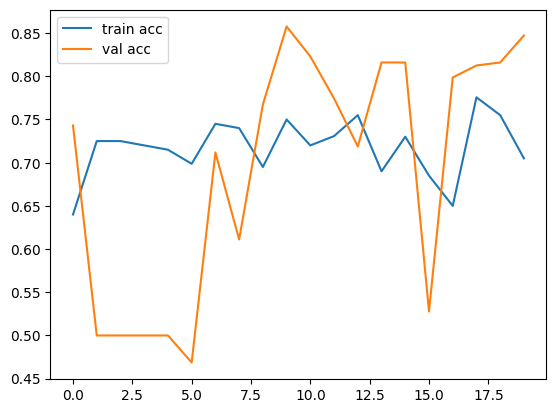

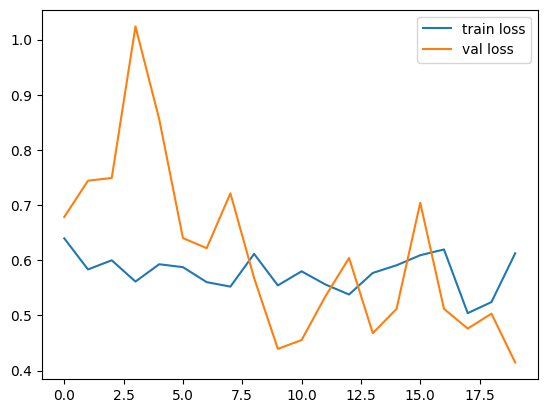

In [11]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('ShuffleNet-acc.png')
plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('ShuffleNet-loss.png')
plt.show()

In [12]:
model.evaluate(test_generator)


106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - AUC: 0.8095 - Precision: 0.9058 - Recall: 0.7213 - accuracy: 0.7764 - loss: 0.4862


[0.48609331250190735,
 0.7819905281066895,
 0.8171685934066772,
 0.8999999761581421,
 0.7142857313156128]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[0.9056959]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Diabetic


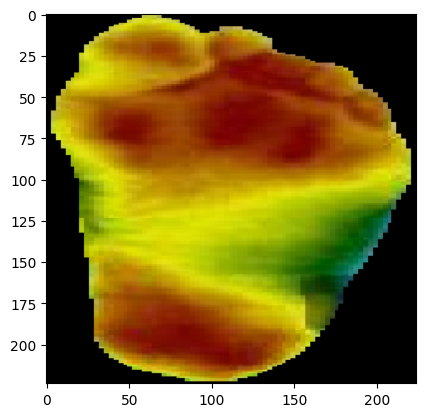

In [13]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('../input/thermography-images-of-diabetic-foot/ThermoDataBase/val/DM Group/DM004_M_L.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[0.3234389]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Normal


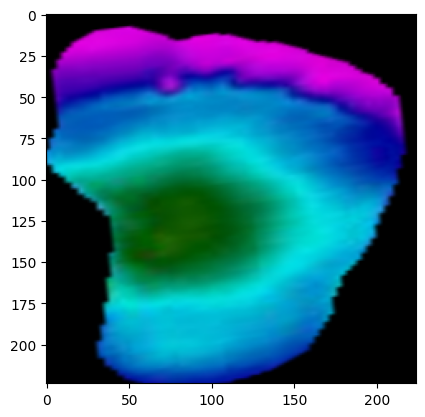

In [14]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('/kaggle/input/thermography-images-of-diabetic-foot/ThermoDataBase/val/Control Group/CG001_M_L-rotated1-rotated1.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))